<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



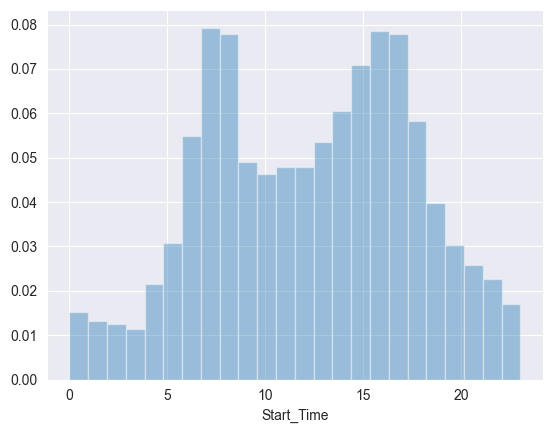

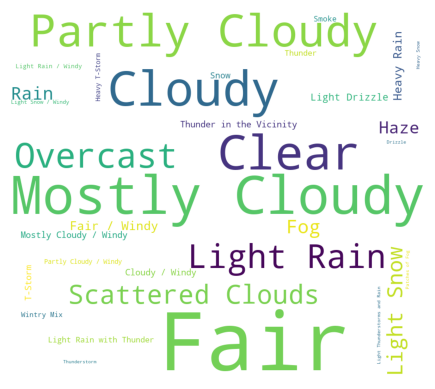

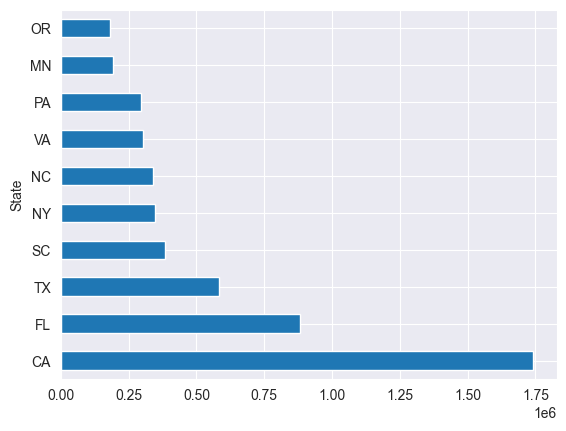

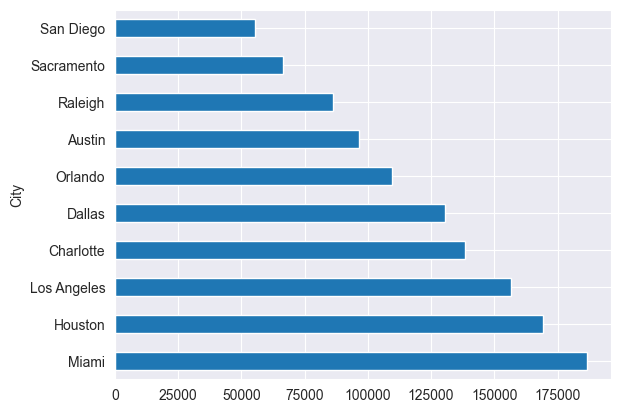

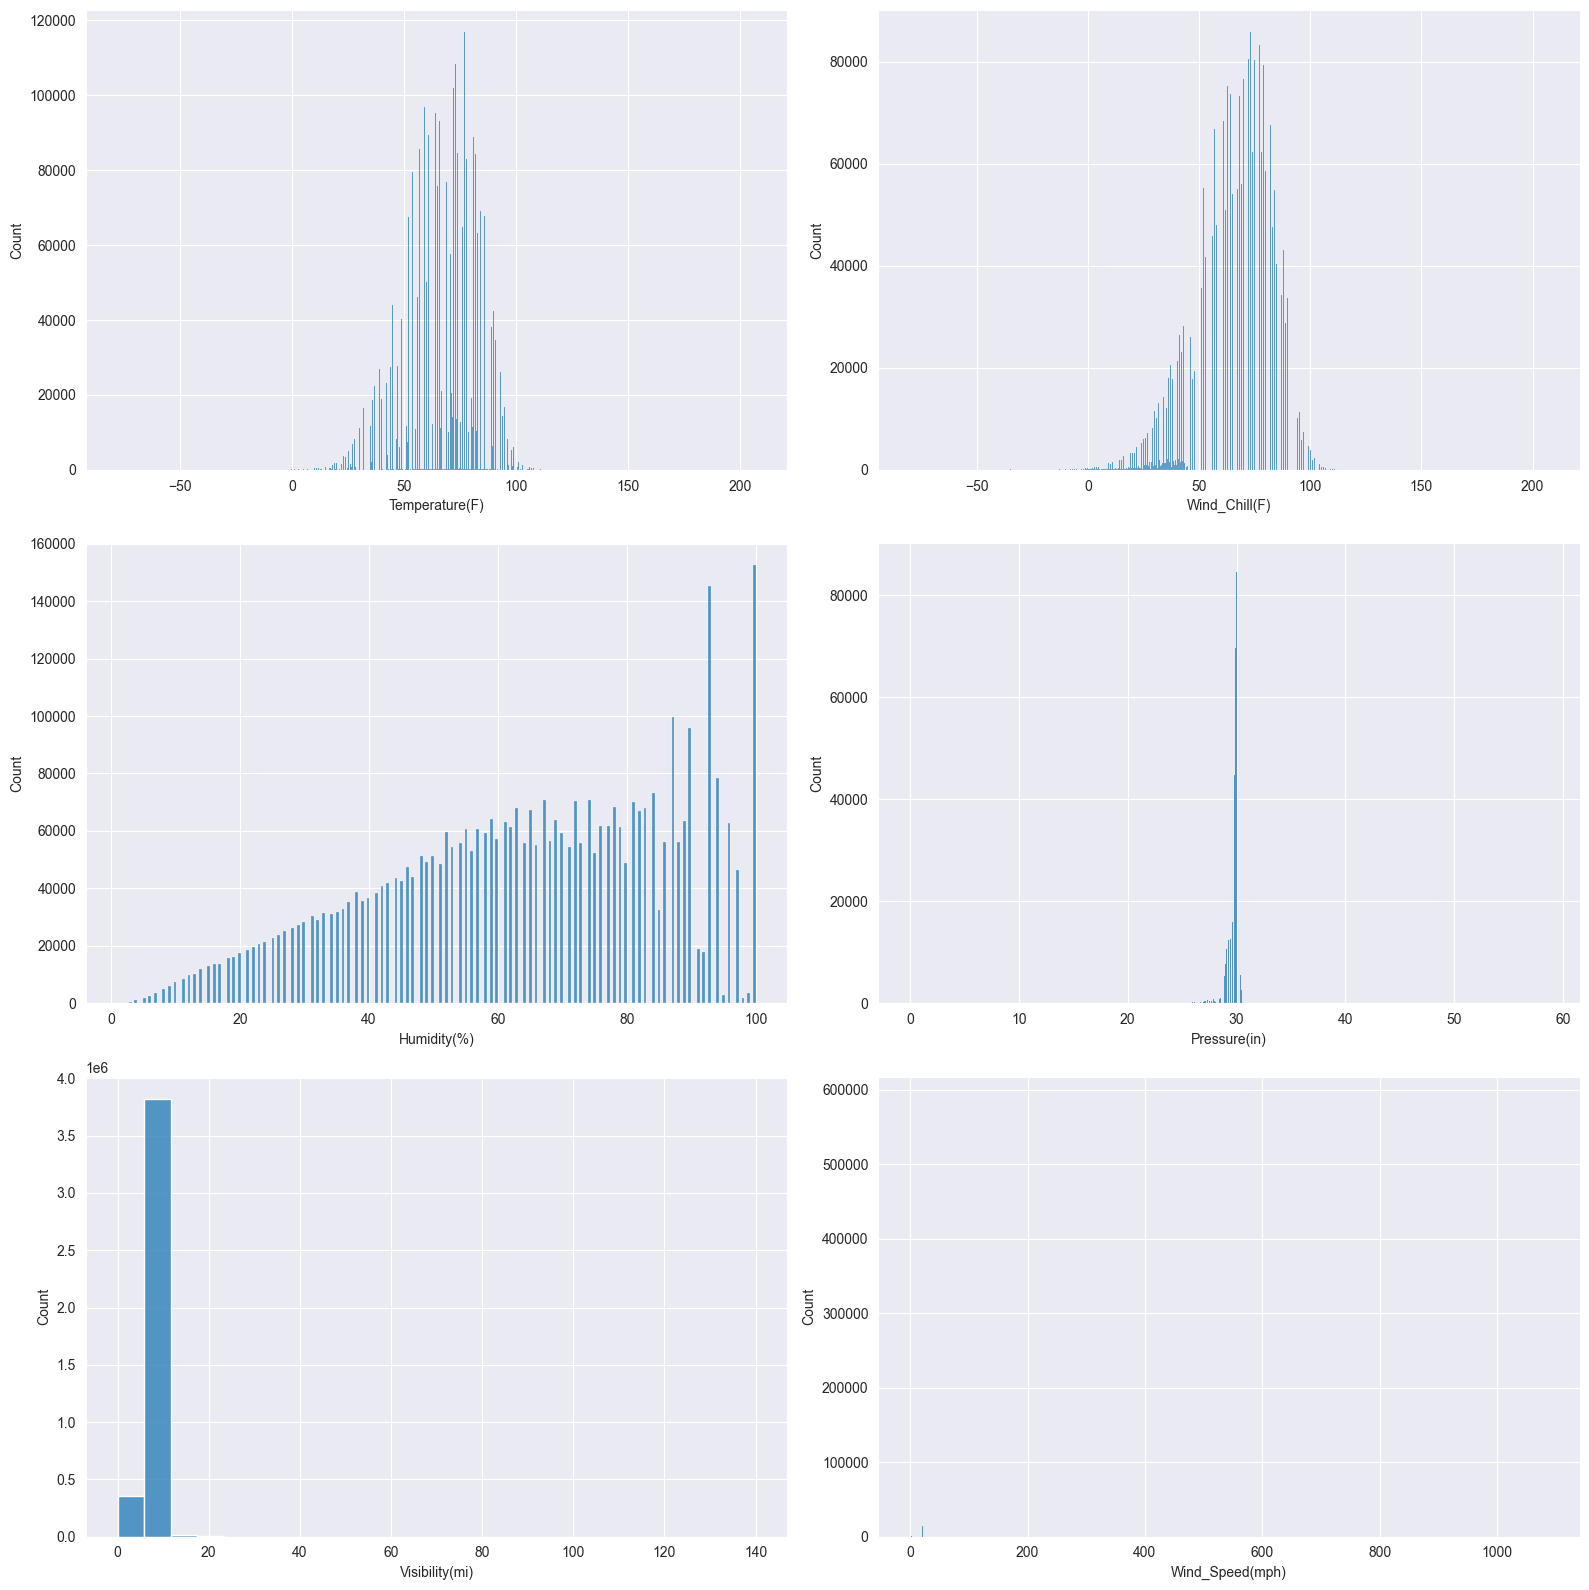

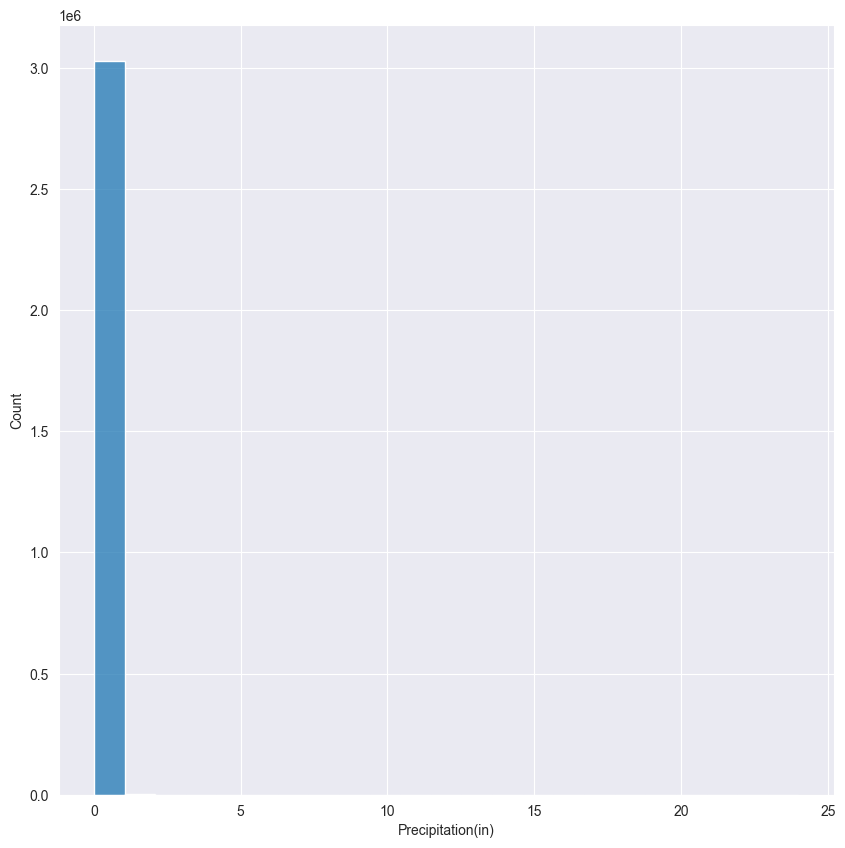


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

<class 'pandas.core.frame.DataFrame'>
Index: 4273178 entries, 728 to 7728393
Data columns (total 40 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   ID                     object         
 1   Severity               int64          
 2   Start_Time             datetime64[ns] 
 3   End_Time               datetime64[ns] 
 4   Start_Lat              float64        
 5   Start_Lng              float64        
 6   Distance(mi)           float64        
 7   Description            object         
 8   Street                 object         
 9   City                   object         
 10  County                 object         
 11  State                  object         
 12  Zipcode                object         
 13  Weather_Timestamp      datetime64[ns] 
 14  Temperature(F)         float64        
 15  Wind_Chill(F)          float64        
 16  Humidity(%)            float64        
 17  Pressure(in)           float64        
 18  Visib

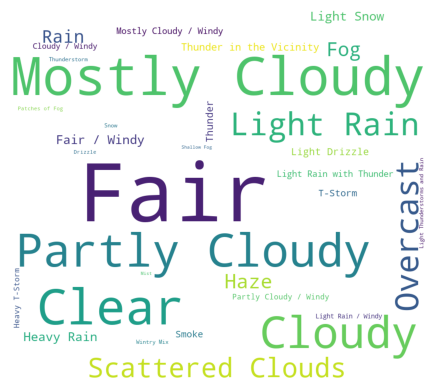

<class 'pandas.core.frame.DataFrame'>
Index: 4191743 entries, 728 to 7728393
Data columns (total 40 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   ID                     object         
 1   Severity               int64          
 2   Start_Time             datetime64[ns] 
 3   End_Time               datetime64[ns] 
 4   Start_Lat              float64        
 5   Start_Lng              float64        
 6   Distance(mi)           float64        
 7   Description            object         
 8   Street                 object         
 9   City                   object         
 10  County                 object         
 11  State                  object         
 12  Zipcode                object         
 13  Weather_Timestamp      datetime64[ns] 
 14  Temperature(F)         float64        
 15  Wind_Chill(F)          float64        
 16  Humidity(%)            float64        
 17  Pressure(in)           float64        
 18  Visib

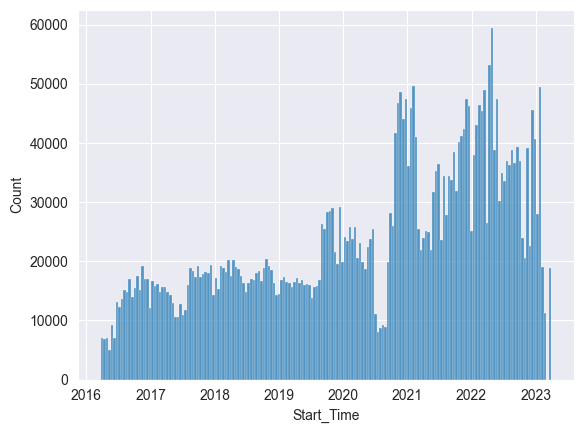

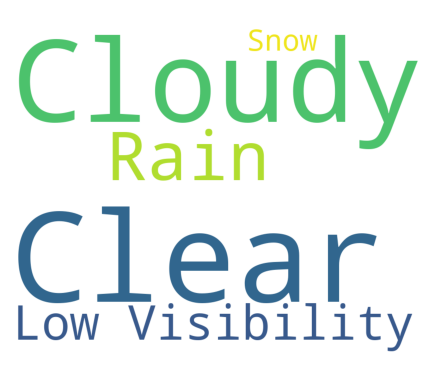

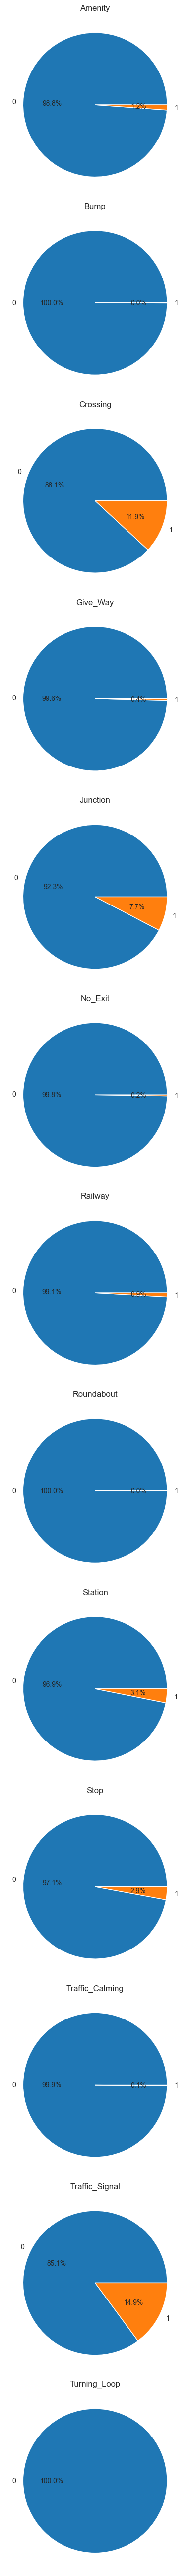

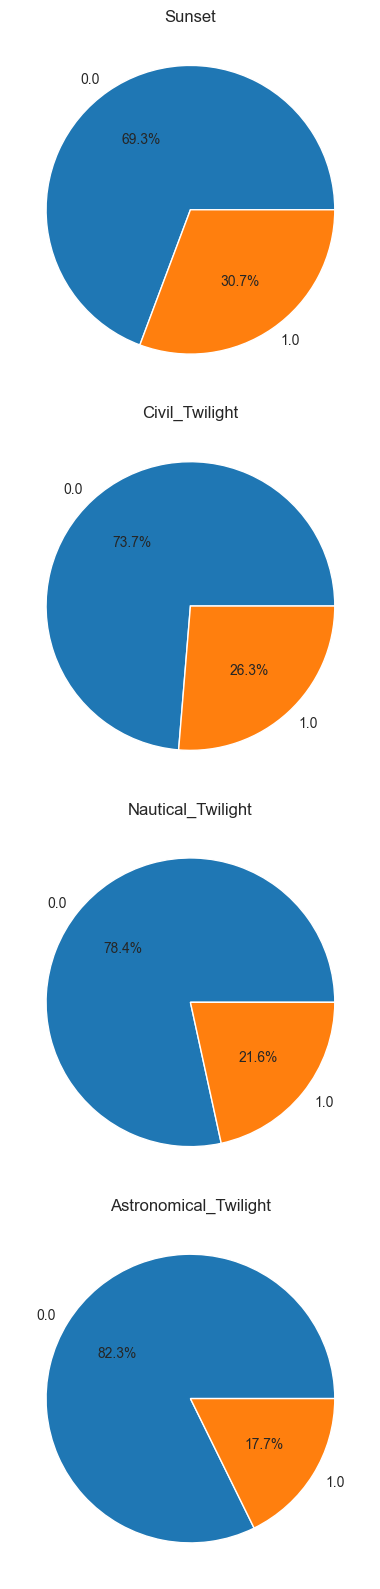

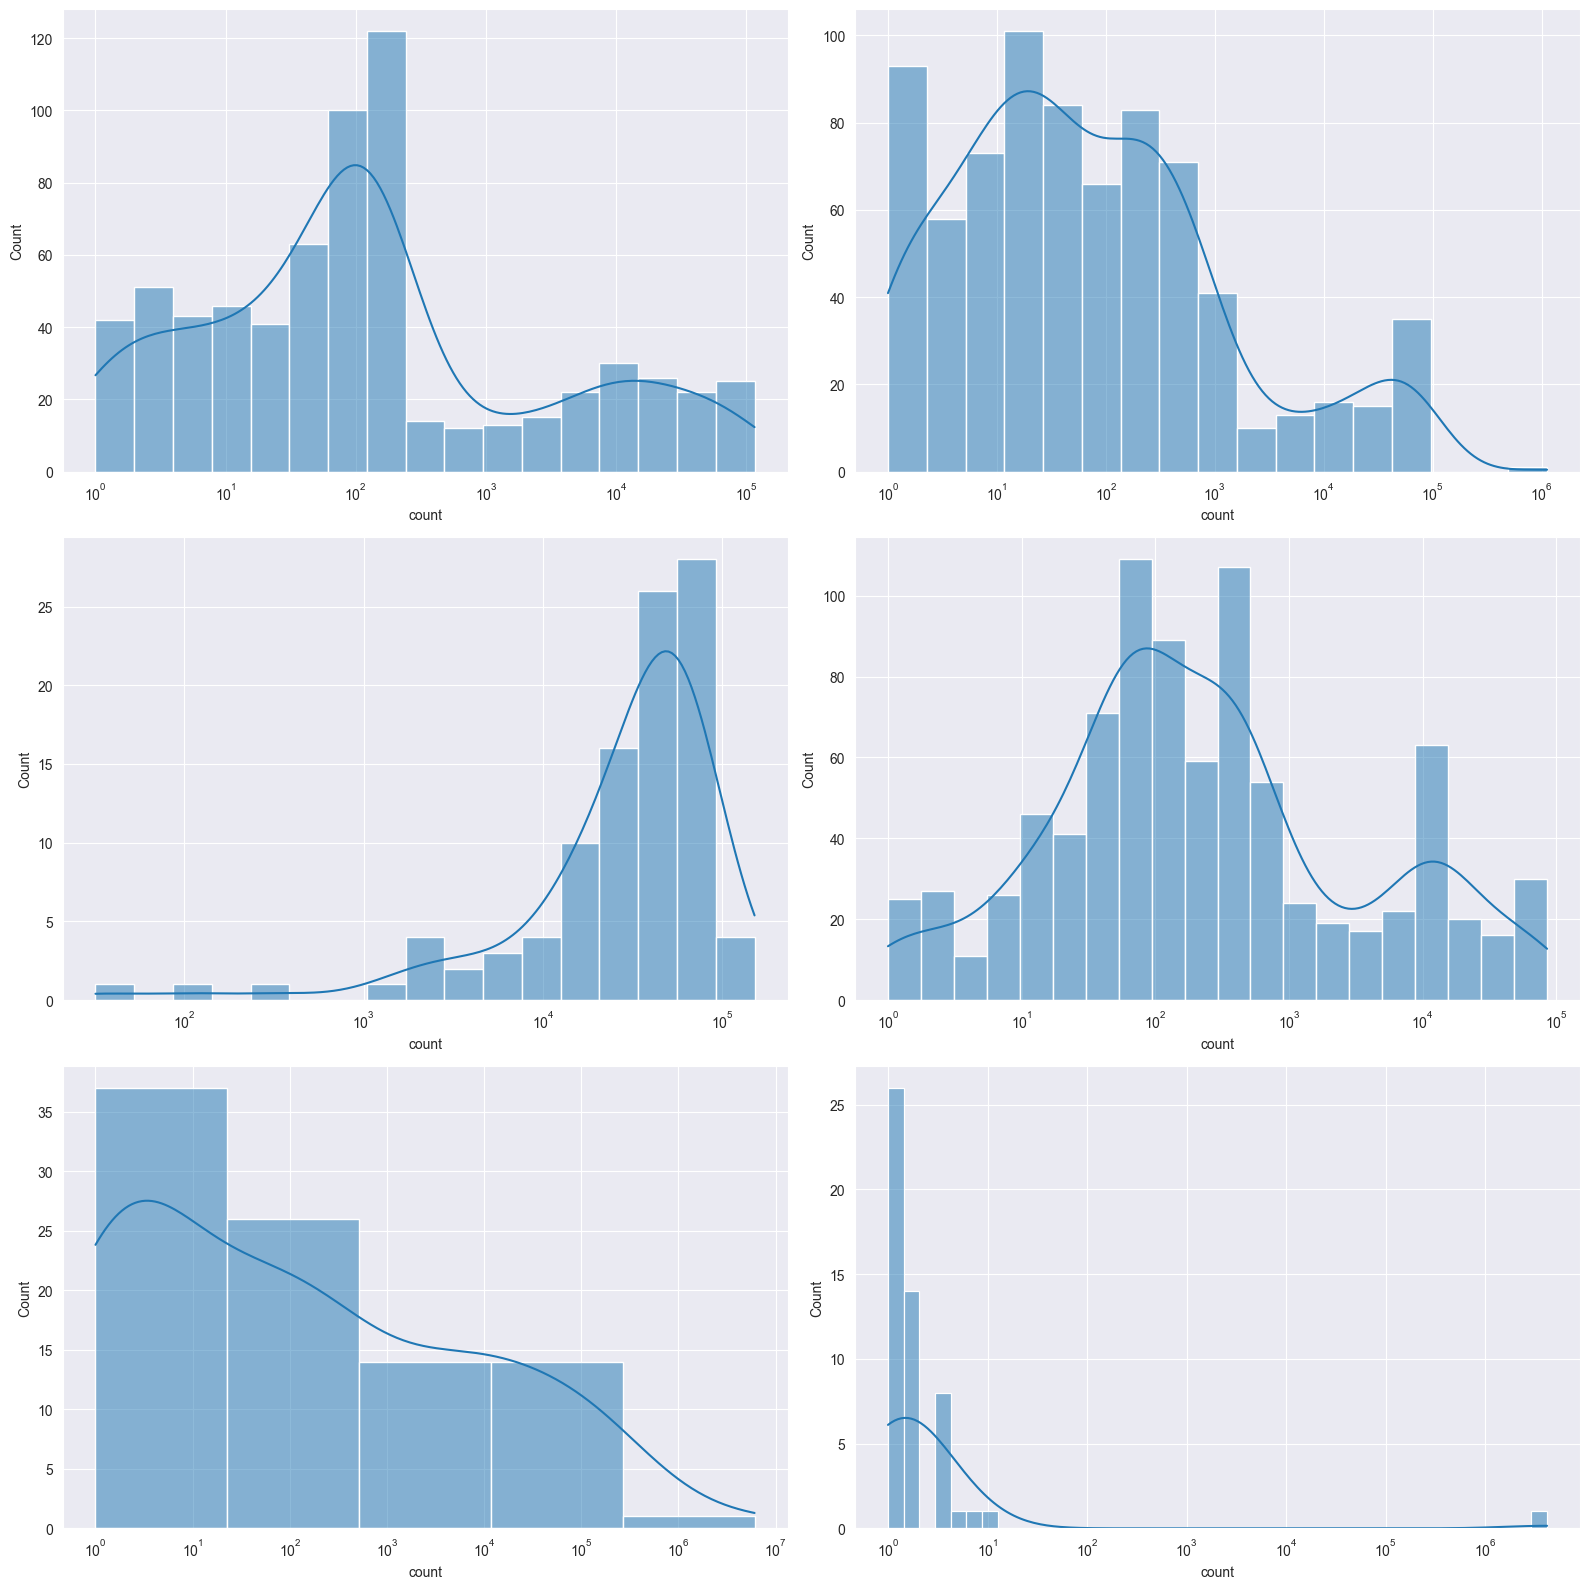

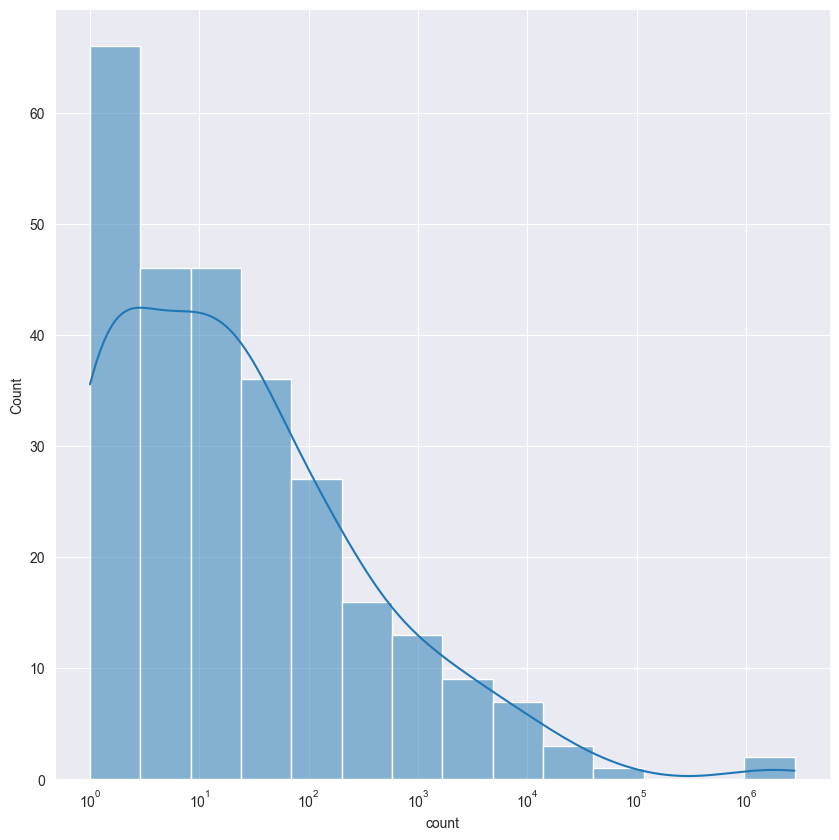

In [11]:
%run EDA.ipynb

In [12]:
# pip install shap

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, r2_score
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from collections import Counter

import shap

In [14]:
# #uploading the dataset
# new_df = pd.read_csv('../data/new_df.csv')

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4191743 entries, 728 to 7728393
Data columns (total 43 columns):
 #   Column                            Dtype          
---  ------                            -----          
 0   ID                                object         
 1   Severity                          int64          
 2   Start_Time                        datetime64[ns] 
 3   End_Time                          datetime64[ns] 
 4   Start_Lat                         float64        
 5   Start_Lng                         float64        
 6   Distance(mi)                      float64        
 7   Description                       object         
 8   Street                            object         
 9   City                              object         
 10  County                            object         
 11  State                             object         
 12  Zipcode                           object         
 13  Weather_Timestamp                 datetime64[ns] 
 14  Tempe

In [18]:
#seeing if we have class imbalanced
new_df['Severity'].value_counts()

Severity
0    3508845
1     682898
Name: count, dtype: int64

In [17]:
#defining the predictor/target variables
X = new_df.drop(columns=['Severity', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
                        'Weather_Timestamp', 'Start_Time', 'End_Time', 'Duration', 'ID'], axis=1)
y = new_df['Severity']

In [19]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [20]:
X_train.shape

(3143807, 31)

In [21]:
X_test.shape

(1047936, 31)

In [22]:
y_train.shape

(3143807,)

In [23]:
y_test.shape

(1047936,)

# Resampling with SMOTE

### Logistic Regression with SMOTE

In [24]:
smote = SMOTE(random_state=88)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_resampled))

Original dataset shape Counter({0: 2631666, 1: 512141})
Resample dataset shape Counter({1: 2631666, 0: 2631666})


In [27]:
logreg = LogisticRegression() #multi_class='multinomial')

In [28]:
logreg.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [29]:
y_pred = logreg.predict(X_test_scaled)

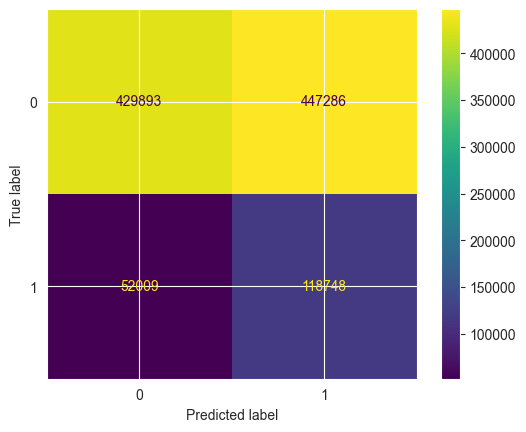

In [30]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test);

In [31]:
(116089+376132)/(116089+376132+427585+44947)

0.5102041662477339

In [32]:
metrics.accuracy_score(y_test, y_pred)

0.5235443767558324

In [33]:
metrics.recall_score(y_test, y_pred)

0.6954209783493502

In [34]:
metrics.precision_score(y_test, y_pred)

0.20978951794415177

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.49      0.63    877179
           1       0.21      0.70      0.32    170757

    accuracy                           0.52   1047936
   macro avg       0.55      0.59      0.48   1047936
weighted avg       0.78      0.52      0.58   1047936



### Random Forest with SMOTE

In [36]:
rf = RandomForestClassifier(random_state=88)

In [37]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=88)

In [38]:
y_pred = rf.predict(X_test)

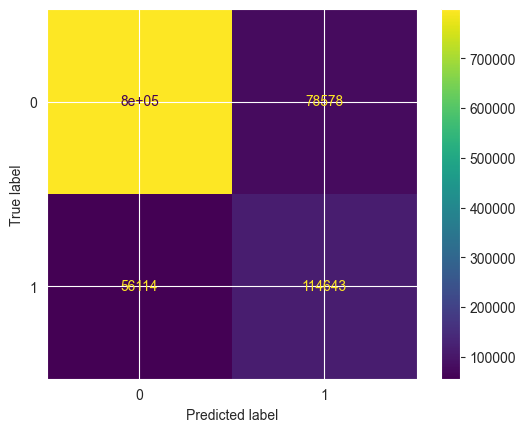

In [39]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test);

In [40]:
metrics.accuracy_score(y_test, y_pred)

0.8714692500305362

In [41]:
metrics.recall_score(y_test, y_pred)

0.6713809682765568

In [42]:
metrics.precision_score(y_test, y_pred)

0.5933257772188323

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92    877179
           1       0.59      0.67      0.63    170757

    accuracy                           0.87   1047936
   macro avg       0.76      0.79      0.78   1047936
weighted avg       0.88      0.87      0.87   1047936



# Resampling with NearMiss

### Logistic Regression with NearMiss

In [30]:
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)

ss = StandardScaler()

ss.fit(X_res)

X_train_scaled = ss.transform(X_res)
X_test_scaled = ss.transform(X_test)

print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 3214835, 1: 644176})
Resampled dataset shape Counter({0: 483140, 1: 483140})


In [31]:
logreg2 = LogisticRegression(multi_class='multinomial')

In [32]:
logreg2.fit(X_train_scaled, y_res)

LogisticRegression(multi_class='multinomial')

In [33]:
y_pred = logreg2.predict(X_test_scaled)

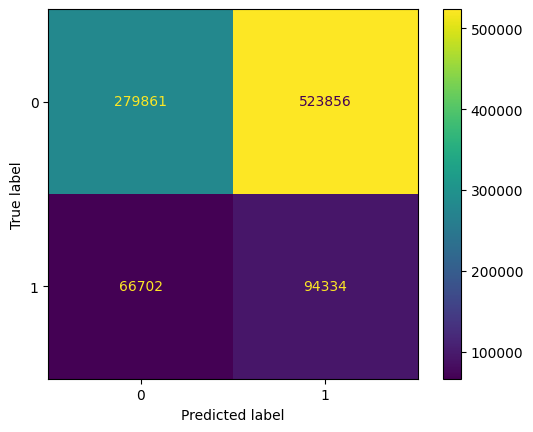

In [34]:
ConfusionMatrixDisplay.from_estimator(logreg2, X_test_scaled, y_test);

In [35]:
metrics.accuracy_score(y_test, y_pred)

0.3878661170268452

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.35      0.49    803717
           1       0.15      0.59      0.24    161036

    accuracy                           0.39    964753
   macro avg       0.48      0.47      0.36    964753
weighted avg       0.70      0.39      0.45    964753



### Random Forest with NearMiss

In [37]:
rf_nearmiss = RandomForestClassifier(random_state=88)

In [38]:
rf_nearmiss.fit(X_res, y_res)

RandomForestClassifier(random_state=88)

In [39]:
y_pred = rf_nearmiss.predict(X_test)

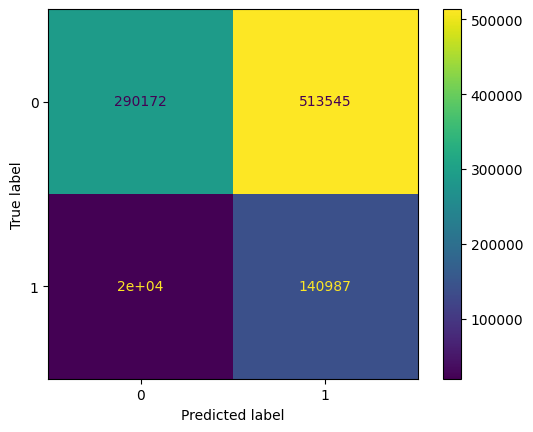

In [40]:
ConfusionMatrixDisplay.from_estimator(rf_nearmiss, X_test, y_test);

In [47]:
metrics.accuracy_score(y_test, y_pred)

0.44691128195507035

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.36      0.52    803717
           1       0.22      0.88      0.35    161036

    accuracy                           0.45    964753
   macro avg       0.58      0.62      0.43    964753
weighted avg       0.82      0.45      0.49    964753



### Random Forest: Feature Importances

In [42]:
feature = X.columns.tolist()
pd.DataFrame({'feature': feature,
              'importance': rf_nearmiss.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,Start_Lng,0.198433
0,Start_Lat,0.195587
2,Distance(mi),0.157610
6,Pressure(in),0.089615
5,Humidity(%),0.084358
3,Temperature(F),0.079748
4,Wind_Chill(F),0.056862
9,Precipitation(in),0.035635
7,Visibility(mi),0.033531
23,Sunset,0.016694


NearMiss is ineffective in addressing class imbalance. The accuracy scores for both Logistic Regression and Random Forest were less than 50% compared with SMOTE with accuracy scores above 50%. Thus, I will be using SMOTE for subsequent models.

# Tuning Hyperparameters with GridSearchCV

In [43]:
counter = Counter(y)
print(counter)

Counter({0: 3214835, 1: 644176})


In [ ]:
pipe = Pipeline([('random_forest', RandomForestClassifier(random_state=88))])

params = {'random_forest__n_estimators': np.arange(20,100,40),
          'random_forest__criterion':['entropy'],
          'random_forest__max_depth': np.arange(8,12,2)}
          # 'random_forest__max_features': np.arange(18,30,4)}

grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train_resampled, y_train_resampled)

In [ ]:
best_est = grid.best_estimator_
best_est

In [26]:
best_est = grid.best_estimator_
best_est

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(max_depth=5, max_features=18,
                                        n_estimators=20, random_state=88))])

In [44]:
#running Random Forest with the best parameters
rf_clf = RandomForestClassifier(max_depth=5, max_features=18, n_estimators=20,
                       random_state=88)
rf_clf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred_rf)

0.7170113442042262

# White Box Models

### Random Forest: Feature Importances

In [ ]:
feature = X.columns.tolist()
pd.DataFrame({'feature': feature,
              'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)

In [ ]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", rf.coef_[i].round(5))

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(rf.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    rf.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

# Black Box Models